In [1]:
import theano
import pymc3 as pm
import numpy as np
import theano.tensor as tt
from matplotlib import pyplot as plt

print('Running on PyMC3 v{}'.format(pm.__version__))

from datetime import datetime
import pickle # python3
import os
now = datetime.now

t_start = now()
print('hello')
print(t_start)

import multiprocessing
ncores = multiprocessing.cpu_count()
print('numcores: {}'.format(ncores))
#%%

Running on PyMC3 v3.8
hello
2020-02-21 13:51:57.972716
numcores: 28


In [2]:
m = [1,2,3];sd=[1,1,1];cov=np.eye(len(sd))*sd;
data1=pm.MvNormal.dist(mu=m,cov=cov).random(size=2000)

m = [7,8,9];sd=[1,1,1];cov=np.eye(len(sd))*sd;
data2=pm.MvNormal.dist(mu=m,cov=cov).random(size=1000)

#m = [15,16,17];sd=[1,1,1];cov=np.eye(len(sd))*sd;
#data3=pm.MvNormal.dist(mu=m,cov=cov).random(size=100)

data=np.vstack((data1,data2))

nsamples=data.shape[0]
ndim=data.shape[1]

print('Multivariate Data, 2 clusters, 123 ; 789,100 each')

Multivariate Data, 2 clusters, 123 ; 789,100 each


In [3]:
# Working model, inferring mus 

def stick_breaking(beta):
    portion_remaining = tt.concatenate([[1], tt.extra_ops.cumprod(1 - beta)[:-1]])
    return beta * portion_remaining

infinity=5
with pm.Model() as model:
    alpha = pm.Gamma('alpha', 1., 1.)
    #beta = pm.Beta('beta', 1., alpha, shape=infinity)
    w = pm.Deterministic('w', stick_breaking(pm.Beta.dist(alpha=1,beta=alpha,shape=infinity).random()))
    w = w/tt.sum(w) # make sure it sums to 1, not .9999
    
    mus=[pm.Uniform('mu{}'.format(i),0,10,shape=ndim) for i in range(infinity)]
    components = [pm.MvNormal.dist(mu=mus[i], cov=np.eye(ndim), shape=data.shape) for i in range(infinity)]
    
    like = pm.Mixture('like', w=w, comp_dists = components, observed=data, shape=(infinity,data.shape[0],data.shape[1]))
    
print('model defined')

model defined


In [4]:
trace = pm.sample(draws=5000,tune=1000,cores=2,init='auto',n_init=5,model=model)
print(pm.summary(trace));

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu4, mu3, mu2, mu1, mu0, alpha]
Sampling 2 chains, 0 divergences: 100%|██████████| 12000/12000 [20:03<00:00,  9.97draws/s]
The acceptance probability does not match the target. It is 0.8888005906744496, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


         mean     sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean   ess_sd  \
alpha   0.994  0.991   0.000    2.786      0.009    0.007   12253.0   9361.0   
w[0]    0.814  0.000   0.814    0.814      0.000    0.000   10000.0  10000.0   
w[1]    0.070  0.000   0.070    0.070      0.000    0.000   10000.0  10000.0   
w[2]    0.011  0.000   0.011    0.011      0.000    0.000   10000.0  10000.0   
w[3]    0.053  0.000   0.053    0.053      0.000    0.000   10000.0  10000.0   
w[4]    0.015  0.000   0.015    0.015      0.000    0.000   10000.0  10000.0   
mu0[0]  6.931  0.045   6.847    7.013      0.001    0.000    4951.0   4949.0   
mu0[1]  8.011  0.046   7.928    8.099      0.001    0.000    4845.0   4845.0   
mu0[2]  9.035  0.051   8.935    9.123      0.001    0.001    2918.0   2918.0   
mu1[0]  4.034  3.039   0.877    7.565      2.140    1.810       2.0      2.0   
mu1[1]  4.966  3.018   1.819    8.519      2.123    1.796       2.0      2.0   
mu1[2]  5.936  3.012   2.801    9.592   

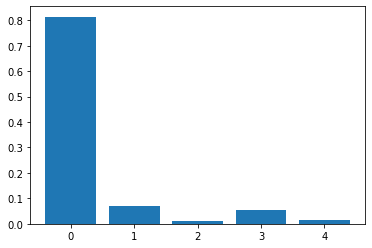

In [5]:
plt.bar(np.arange(infinity),trace['w'].mean(axis=0));

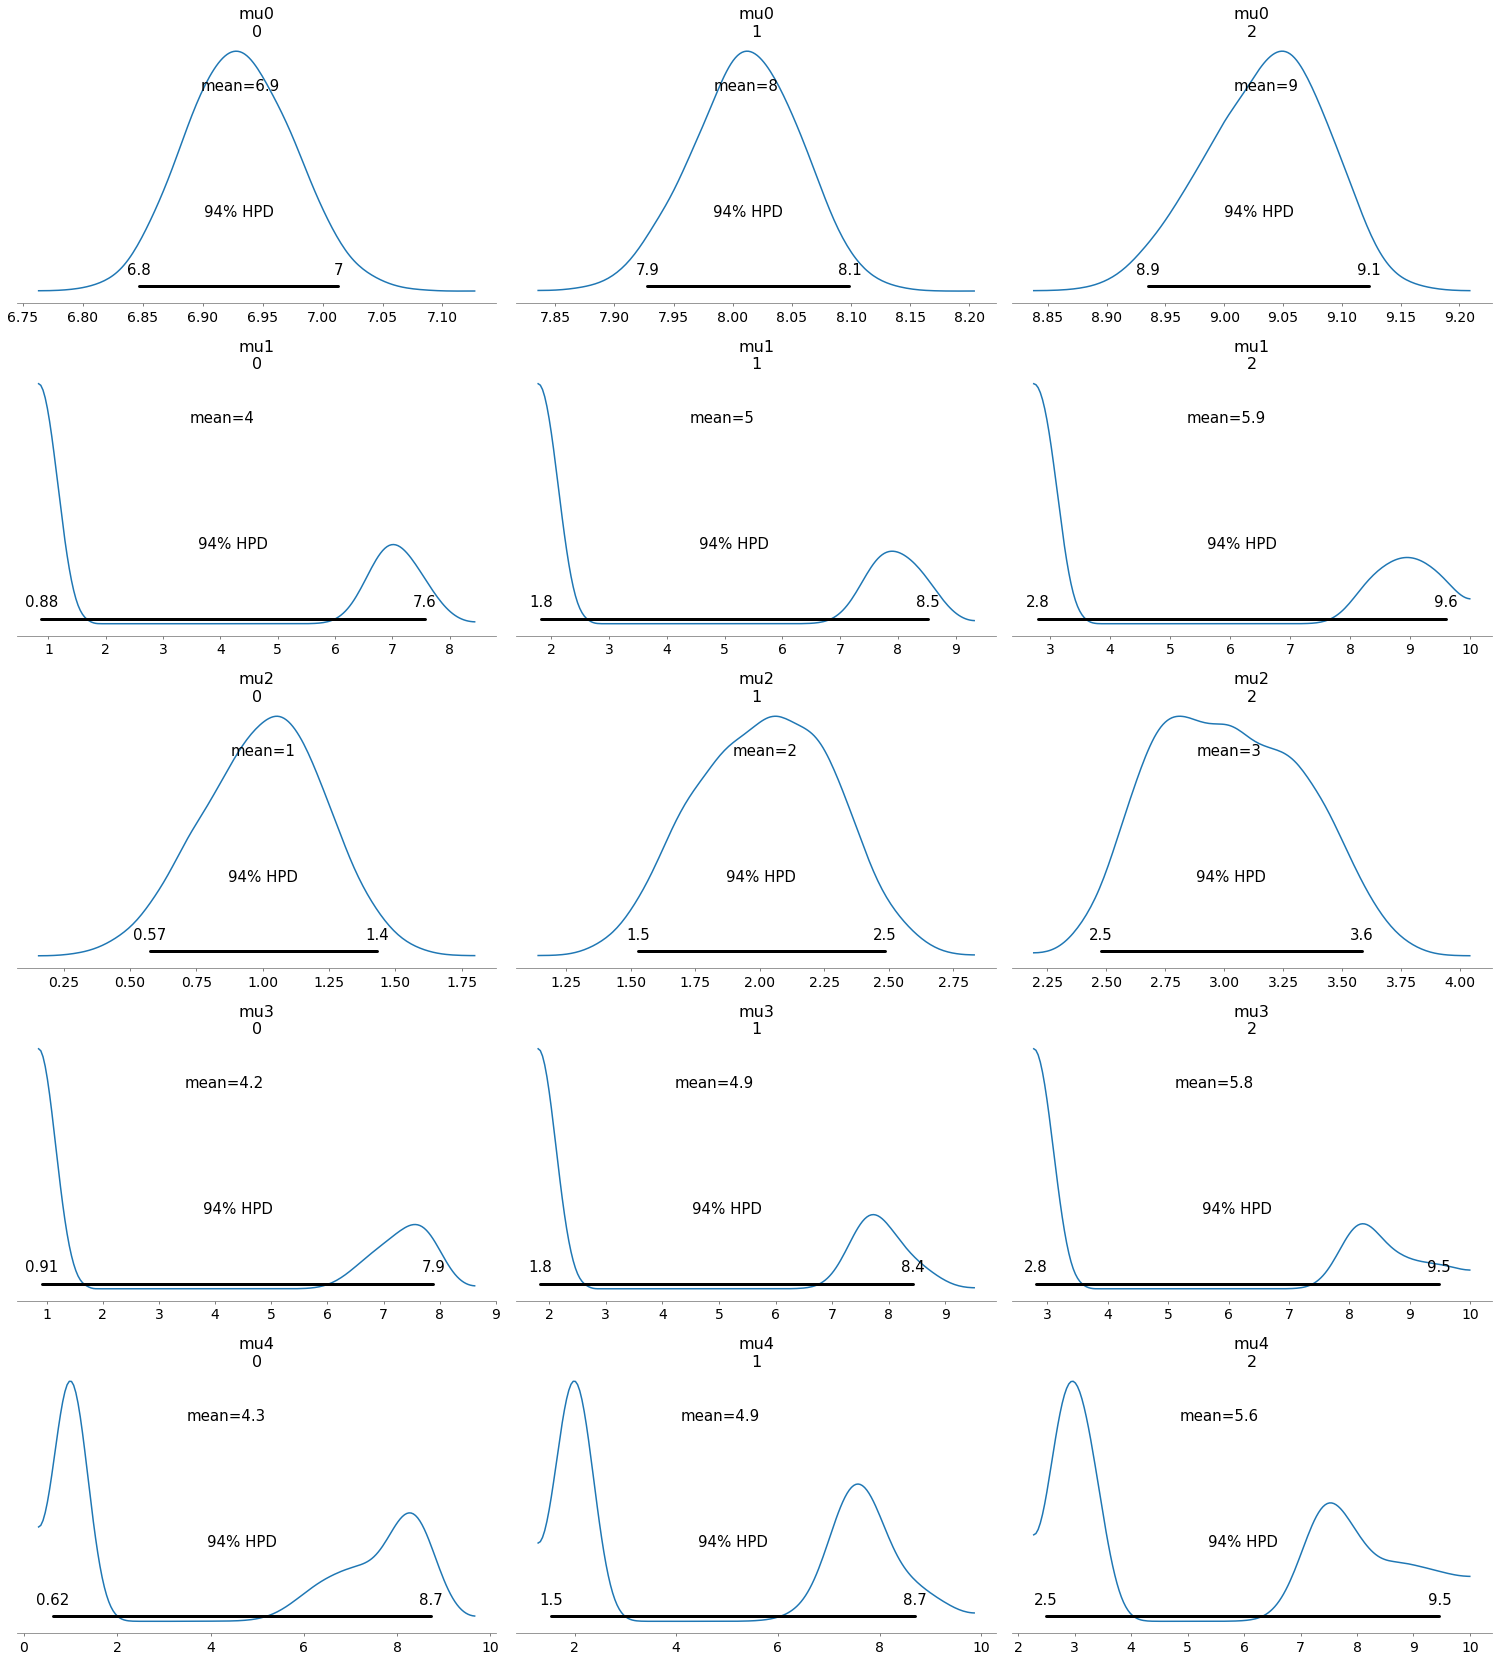

In [6]:
pm.plot_posterior(data=trace,var_names=['mu0','mu1','mu2','mu3','mu4']);
#pm.plot_posterior(data=trace,var_names=['mu1'],backend="matplotlib");
#pm.plot_posterior(data=trace,var_names=['mu2'],backend="matplotlib");
#pm.plot_posterior(data=trace,var_names=['mu3'],backend="matplotlib");
#pm.plot_posterior(data=trace,var_names=['mu4'],backend="matplotlib");

In [7]:
t_finish=now()

In [8]:
print('Time it took to run {}'.format(str(t_finish-t_start)))

Time it took to run 0:22:48.229699


In [9]:
#with model:
#    trace = pm.sample(draws=5000,cores=8,tune=500)    

In [10]:
#with model:
#    trace = pm.find_MAP()